In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import concat
import copy
import time

# 时间序列转换为监督学习
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

serScada=pd.read_csv('serScada.csv', index_col=0)
# 字符转标准时间索引
serScada.index = pd.to_datetime(serScada.index)

date_pro = serScada.iloc[:,[1,2,3]].values

# 拟合计算放缩比例等参数，并存储在 scaler
data_norm = date_pro  # 字典对象也可以

# to supervised learning
n_timesteps = 10  # 之前的时刻数量
n_features = data_norm.shape[1]  # 数据集中输入特征数量
data_supervised = series_to_supervised(data_norm, n_timesteps, 1)  # 包含 t 时刻之前的 timestep 个时间点，以及 t 时刻数据，以 t 时刻为预测对象

# drop columns we don't want to predict
relain = np.array([3])  # array([3]) 保留第几个变量(从1计数)，即预测对象
data_supervised_droped = copy.deepcopy(data_supervised)  # 深拷贝则不会改变原始字典对象内容
remov = np.array([x for x in range(data_norm.shape[1])]) + n_timesteps*n_features  # array([30, 31, 32]) t 时刻所有参数列序号
remov = np.delete(remov,relain-1)  # array([30, 31]) 要删除的对象
data_supervised_droped.drop(data_supervised_droped.columns[remov], axis=1, inplace=True)  # 去掉输出当中不需要预测的参数列 [-1,-2,-3,-4,-5,-6]

# split into train and test sets
n_train_num = int(len(data_supervised_droped)*0.8)  # 规定训练集数据数量，要小于数据量总数，在后面设置reshape设置样本个数、时间步长要注意数量对应
train = data_supervised_droped.values[:n_train_num, :]  # 按行切片，从0到n-1行，也就是从头开始总共 n 行数据
test = data_supervised_droped.values[n_train_num:, :]  # 按行切片
# y = data_supervised_droped.values[:,n_timesteps*n_features][n_train_num:]  # 测试集的 y，用于后续结果比较

# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]  # 按列切片，从起始位置到-2列：-1列
X_test, y_test = test[:, :-1], test[:, -1]  # x 和 y 变量类型都是<class 'numpy.ndarray'>
print(len(y_test))
y_test

10510


array([   0.        ,    0.        ,    0.        , ..., 1788.28475526,
       2418.38250336, 2779.18409628])

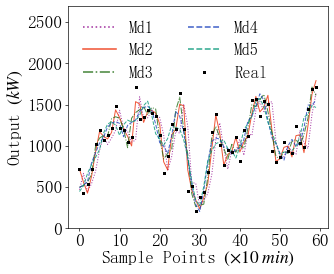

In [129]:
s = 100
e = s+6*10
y = y_test[s:e]
# print(y)

result = pd.read_csv('./predict-wind-turbine/compare_filter/SG_3_2.csv', index_col=False)
y0 = result.values[s:e,1]
# print(y0)

result = pd.read_csv('./predict-wind-turbine/compare_filter/SG_5_2.csv', index_col=False)
y1 = result.values[s:e,1]
# print(y1)

result = pd.read_csv('./predict-wind-turbine/compare_filter/SG_7_2.csv', index_col=False)
y2 = result.values[s:e,1]
# print(y2)

result = pd.read_csv('./predict-wind-turbine/compare_filter/SG_9_2.csv', index_col=False)
y3 = result.values[s:e,1]
# print(y3)

result = pd.read_csv('./predict-wind-turbine/compare_filter/SG_11_2.csv', index_col=False)
y4 = result.values[s:e,1]
# print(y4)

plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
config = {
            "font.family": 'serif',
            "font.size": 21,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
rcParams.update(config)
fig, ax1 = plt.subplots(figsize=(6, 5), dpi=60)
# 绘图
# 自变量
x = np.array(range(len(y)))
# y = record[2]
colors = ['#8e058bca', '#ec2d07ca', '#1d6a0fca', '#173ebcca', '#009675ca', 'Black']
markers = ['s', 'D', 'X', '*', 'P']
msize = [0,0,0,0,0,3.6]#[8.5, 7.8, 10.8, 15, 10.8]
plt.plot(x, y0, label=r'Md1', linewidth=1.2, linestyle=':', color=colors[0], marker=markers[0], markersize = msize[0], markerfacecolor=colors[0], markeredgecolor='#FD4040', markeredgewidth=0)
plt.plot(x, y1, label=r'Md2', linewidth=1.2, linestyle='-', color=colors[1], marker=markers[1], markersize = msize[1], markerfacecolor=colors[1], markeredgecolor='#249166', markeredgewidth=0)
plt.plot(x, y2, label=r'Md3', linewidth=1.2, linestyle='-.', color=colors[2], marker=markers[2], markersize = msize[2], markerfacecolor=colors[2], markeredgecolor='#FD4040', markeredgewidth=0)
plt.plot(x, y3, label=r'Md4', linewidth=1.2, linestyle='--', color=colors[3], marker=markers[3], markersize = msize[3], markerfacecolor=colors[3], markeredgecolor='#FD4040', markeredgewidth=0)
plt.plot(x, y4, label=r'Md5', linewidth=1.2, linestyle='--', color=colors[4], marker=markers[4], markersize = msize[4], markerfacecolor=colors[4], markeredgecolor='#FD4040', markeredgewidth=0)
plt.plot(x, y, label=r'Real', linewidth=0, linestyle='', color=colors[5], marker=markers[0], markersize = msize[5], markerfacecolor=colors[5], markeredgecolor='#FD4040', markeredgewidth=0)

# 设置坐标系
# plt.xlim(.5, 6.5)
plt.ylim(0, 2700)
# 坐标轴名
ax1.set_xlabel(r'Sample Points $( \times 10 \; min )$', labelpad=2)#, fontsize=10
ax1.set_ylabel('Output $(kW)$', labelpad=2)
#设置主刻度标签的位置
ax1.xaxis.set_major_locator(plt.MultipleLocator(10)) #将轴主刻度标签设置为 的倍数
# ax1.yaxis.set_major_locator(plt.MultipleLocator(.2))

legend = plt.legend(loc='upper left',frameon=False, ncol=2,fancybox=False,
                    facecolor='white', fontsize=20)#loc='upper left', ,edgecolor='black', fontsize=7, bbox_to_anchor=(.6, 1)
# set the linewidth of each legend object
for legobj in legend.legendHandles:
	legobj.set_linewidth(1.9)

plt.tight_layout()
plt.savefig('./output/'+time.strftime('%Y_%m_%d_%H_%M_%S', time.localtime())+'.jpg', dpi=300)
# plt.savefig('./output/'+time.strftime('%Y_%m_%d_%H_%M_%S', time.localtime())+'.tiff', dpi=300)
plt.show()
plt.close(fig)

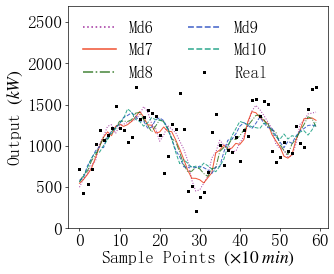

In [130]:
s = 100
e = s+6*10
y = y_test[s:e]
# print(y)

result = pd.read_csv('./predict-wind-turbine/compare_filter/SG_13_2.csv', index_col=False)
y0 = result.values[s:e,1]
# print(y0)

result = pd.read_csv('./predict-wind-turbine/compare_filter/SG_15_2.csv', index_col=False)
y1 = result.values[s:e,1]
# print(y1)

result = pd.read_csv('./predict-wind-turbine/compare_filter/SG_17_2.csv', index_col=False)
y2 = result.values[s:e,1]
# print(y2)

result = pd.read_csv('./predict-wind-turbine/compare_filter/SG_19_2.csv', index_col=False)
y3 = result.values[s:e,1]
# print(y3)

result = pd.read_csv('./predict-wind-turbine/compare_filter/SG_21_2.csv', index_col=False)
y4 = result.values[s:e,1]
# print(y4)

plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
config = {
            "font.family": 'serif',
            "font.size": 21,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
rcParams.update(config)
fig, ax1 = plt.subplots(figsize=(6, 5), dpi=60)
# 绘图
# 自变量
x = np.array(range(len(y)))
# y = record[2]
colors = ['#8e058bca', '#ec2d07ca', '#1d6a0fca', '#173ebcca', '#009675ca', 'Black']
markers = ['s', 'D', 'X', '*', 'P']
msize = [0,0,0,0,0,3.6]#[8.5, 7.8, 10.8, 15, 10.8]
plt.plot(x, y0, label=r'Md6', linewidth=1.2, linestyle=':', color=colors[0], marker=markers[0], markersize = msize[0], markerfacecolor=colors[0], markeredgecolor='#FD4040', markeredgewidth=0)
plt.plot(x, y1, label=r'Md7', linewidth=1.2, linestyle='-', color=colors[1], marker=markers[1], markersize = msize[1], markerfacecolor=colors[1], markeredgecolor='#249166', markeredgewidth=0)
plt.plot(x, y2, label=r'Md8', linewidth=1.2, linestyle='-.', color=colors[2], marker=markers[2], markersize = msize[2], markerfacecolor=colors[2], markeredgecolor='#FD4040', markeredgewidth=0)
plt.plot(x, y3, label=r'Md9', linewidth=1.2, linestyle='--', color=colors[3], marker=markers[3], markersize = msize[3], markerfacecolor=colors[3], markeredgecolor='#FD4040', markeredgewidth=0)
plt.plot(x, y4, label=r'Md10', linewidth=1.2, linestyle='--', color=colors[4], marker=markers[4], markersize = msize[4], markerfacecolor=colors[4], markeredgecolor='#FD4040', markeredgewidth=0)
plt.plot(x, y, label=r'Real', linewidth=0, linestyle='', color=colors[5], marker=markers[0], markersize = msize[5], markerfacecolor=colors[5], markeredgecolor='#FD4040', markeredgewidth=0)

# 设置坐标系
# plt.xlim(.5, 6.5)
plt.ylim(0, 2700)
# 坐标轴名
ax1.set_xlabel(r'Sample Points $( \times 10 \; min )$', labelpad=2)#, fontsize=10
ax1.set_ylabel('Output $(kW)$', labelpad=2)
#设置主刻度标签的位置
ax1.xaxis.set_major_locator(plt.MultipleLocator(10)) #将轴主刻度标签设置为 的倍数
# ax1.yaxis.set_major_locator(plt.MultipleLocator(.2))

legend = plt.legend(loc='upper left',frameon=False, ncol=2,fancybox=False,
                    facecolor='white', fontsize=20)#loc='upper left', ,edgecolor='black', fontsize=7, bbox_to_anchor=(.6, 1)
# set the linewidth of each legend object
for legobj in legend.legendHandles:
	legobj.set_linewidth(1.9)

plt.tight_layout()
plt.savefig('./output/'+time.strftime('%Y_%m_%d_%H_%M_%S', time.localtime())+'.jpg', dpi=300)
# plt.savefig('./output/'+time.strftime('%Y_%m_%d_%H_%M_%S', time.localtime())+'.tiff', dpi=300)
plt.show()
plt.close(fig)

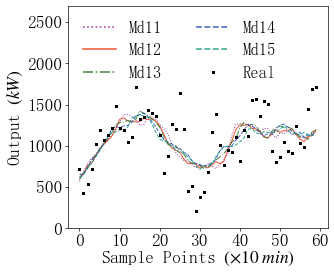

In [131]:
s = 100
e = s+6*10
y = y_test[s:e]
# print(y)

result = pd.read_csv('./predict-wind-turbine/compare_filter/SG_23_2.csv', index_col=False)
y0 = result.values[s:e,1]
# print(y0)

result = pd.read_csv('./predict-wind-turbine/compare_filter/SG_25_2.csv', index_col=False)
y1 = result.values[s:e,1]
# print(y1)

result = pd.read_csv('./predict-wind-turbine/compare_filter/SG_27_2.csv', index_col=False)
y2 = result.values[s:e,1]
# print(y2)

result = pd.read_csv('./predict-wind-turbine/compare_filter/SG_29_2.csv', index_col=False)
y3 = result.values[s:e,1]
# print(y3)

result = pd.read_csv('./predict-wind-turbine/compare_filter/SG_31_2.csv', index_col=False)
y4 = result.values[s:e,1]
# print(y4)

plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
config = {
            "font.family": 'serif',
            "font.size": 21,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
rcParams.update(config)
fig, ax1 = plt.subplots(figsize=(6, 5), dpi=60)
# 绘图
# 自变量
x = np.array(range(len(y)))
# y = record[2]
colors = ['#8e058bca', '#ec2d07ca', '#1d6a0fca', '#173ebcca', '#009675ca', 'Black']
markers = ['s', 'D', 'X', '*', 'P']
msize = [0,0,0,0,0,3.6]#[8.5, 7.8, 10.8, 15, 10.8]
plt.plot(x, y0, label=r'Md11', linewidth=1.2, linestyle=':', color=colors[0], marker=markers[0], markersize = msize[0], markerfacecolor=colors[0], markeredgecolor='#FD4040', markeredgewidth=0)
plt.plot(x, y1, label=r'Md12', linewidth=1.2, linestyle='-', color=colors[1], marker=markers[1], markersize = msize[1], markerfacecolor=colors[1], markeredgecolor='#249166', markeredgewidth=0)
plt.plot(x, y2, label=r'Md13', linewidth=1.2, linestyle='-.', color=colors[2], marker=markers[2], markersize = msize[2], markerfacecolor=colors[2], markeredgecolor='#FD4040', markeredgewidth=0)
plt.plot(x, y3, label=r'Md14', linewidth=1.2, linestyle='--', color=colors[3], marker=markers[3], markersize = msize[3], markerfacecolor=colors[3], markeredgecolor='#FD4040', markeredgewidth=0)
plt.plot(x, y4, label=r'Md15', linewidth=1.2, linestyle='--', color=colors[4], marker=markers[4], markersize = msize[4], markerfacecolor=colors[4], markeredgecolor='#FD4040', markeredgewidth=0)
plt.plot(x, y, label=r'Real', linewidth=0, linestyle='', color=colors[5], marker=markers[0], markersize = msize[5], markerfacecolor=colors[5], markeredgecolor='#FD4040', markeredgewidth=0)

# 设置坐标系
# plt.xlim(.5, 6.5)
plt.ylim(0, 2700)
# 坐标轴名
ax1.set_xlabel(r'Sample Points $( \times 10 \; min )$', labelpad=2)#, fontsize=10
ax1.set_ylabel('Output $(kW)$', labelpad=2)
#设置主刻度标签的位置
ax1.xaxis.set_major_locator(plt.MultipleLocator(10)) #将轴主刻度标签设置为 的倍数
# ax1.yaxis.set_major_locator(plt.MultipleLocator(.2))

legend = plt.legend(loc='upper left',frameon=False, ncol=2,fancybox=False,
                    facecolor='white', fontsize=20)#loc='upper left', ,edgecolor='black', fontsize=7, bbox_to_anchor=(.6, 1)
# set the linewidth of each legend object
for legobj in legend.legendHandles:
	legobj.set_linewidth(1.9)

plt.tight_layout()
plt.savefig('./output/'+time.strftime('%Y_%m_%d_%H_%M_%S', time.localtime())+'.jpg', dpi=300)
# plt.savefig('./output/'+time.strftime('%Y_%m_%d_%H_%M_%S', time.localtime())+'.tiff', dpi=300)
plt.show()
plt.close(fig)

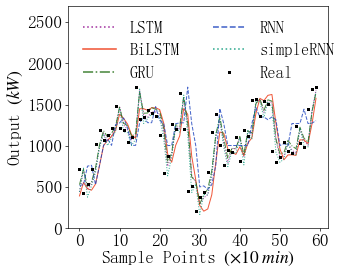

In [142]:
s = 100
e = s+6*10
y = y_test[s:e]
# print(y)

result = pd.read_csv('./predict-wind-turbine/LSTM/prediction_lstm.csv', index_col=False)
y0 = result.values[s:e,1]
# print(y0)

result = pd.read_csv('./predict-wind-turbine/BiLSTM/prediction_bilstm.csv', index_col=False)
y1 = result.values[s:e,1]
# print(y1)

result = pd.read_csv('./predict-wind-turbine/GRU/prediction_GRU.csv', index_col=False)
y2 = result.values[s:e,1]
# print(y2)

result = pd.read_csv('./predict-wind-turbine/RNN/prediction_RNN.csv', index_col=False)
y3 = result.values[s:e,1]
# print(y3)

result = pd.read_csv('./predict-wind-turbine/simpleRNN/prediction_simpleRNN.csv', index_col=False)
y4 = result.values[s:e,1]
# print(y4)

plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
config = {
            "font.family": 'serif',
            "font.size": 21,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
rcParams.update(config)
fig, ax1 = plt.subplots(figsize=(6, 5), dpi=60)
# 绘图
# 自变量
x = np.array(range(len(y)))
# y = record[2]
colors = ['#8e058bca', '#ec2d07ca', '#1d6a0fca', '#173ebcca', '#009675ca', 'Black']
markers = ['s', 'D', 'X', '*', 'P']
msize = [0,0,0,0,0,3.6]#[8.5, 7.8, 10.8, 15, 10.8]
plt.plot(x, y0, label=r'LSTM', linewidth=1.2, linestyle=':', color=colors[0], marker=markers[0], markersize = msize[0], markerfacecolor=colors[0], markeredgecolor='#FD4040', markeredgewidth=0)
plt.plot(x, y1, label=r'BiLSTM', linewidth=1.2, linestyle='-', color=colors[1], marker=markers[1], markersize = msize[1], markerfacecolor=colors[1], markeredgecolor='#249166', markeredgewidth=0)
plt.plot(x, y2, label=r'GRU', linewidth=1.2, linestyle='-.', color=colors[2], marker=markers[2], markersize = msize[2], markerfacecolor=colors[2], markeredgecolor='#FD4040', markeredgewidth=0)
plt.plot(x, y3, label=r'RNN', linewidth=1.2, linestyle='--', color=colors[3], marker=markers[3], markersize = msize[3], markerfacecolor=colors[3], markeredgecolor='#FD4040', markeredgewidth=0)
plt.plot(x, y4, label=r'simpleRNN', linewidth=1.2, linestyle=':', color=colors[4], marker=markers[4], markersize = msize[4], markerfacecolor=colors[4], markeredgecolor='#FD4040', markeredgewidth=0)
plt.plot(x, y, label=r'Real', linewidth=0, linestyle='', color=colors[5], marker=markers[0], markersize = msize[5], markerfacecolor=colors[5], markeredgecolor='#FD4040', markeredgewidth=0)

# 设置坐标系
# plt.xlim(.5, 6.5)
plt.ylim(0, 2700)
# 坐标轴名
ax1.set_xlabel(r'Sample Points $( \times 10 \; min )$', labelpad=2)#, fontsize=10
ax1.set_ylabel('Output $(kW)$', labelpad=2)
#设置主刻度标签的位置
ax1.xaxis.set_major_locator(plt.MultipleLocator(10)) #将轴主刻度标签设置为 的倍数
# ax1.yaxis.set_major_locator(plt.MultipleLocator(.2))

legend = plt.legend(loc='upper left',frameon=False, ncol=2,fancybox=False,
                    facecolor='white', fontsize=20)#loc='upper left', ,edgecolor='black', fontsize=7, bbox_to_anchor=(.6, 1)
# set the linewidth of each legend object
for legobj in legend.legendHandles:
	legobj.set_linewidth(1.9)

plt.tight_layout()
plt.savefig('./output/'+time.strftime('%Y_%m_%d_%H_%M_%S', time.localtime())+'.jpg', dpi=300)
# plt.savefig('./output/'+time.strftime('%Y_%m_%d_%H_%M_%S', time.localtime())+'.tiff', dpi=300)
plt.show()
plt.close(fig)

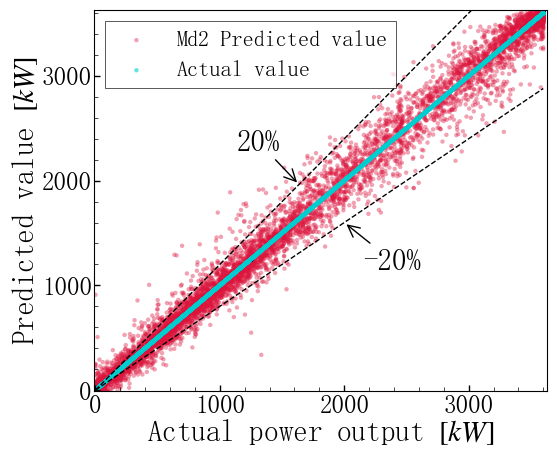

In [109]:

s=0
e=9000
result = pd.read_csv('./res/SG_5_2.csv', index_col=False)
y1 = result.values[s:e,1]
# print(y_test[s:e])
# print(y1)

yy = 3600
err = 0.2
loc = 1800
loc1 = (2*loc)/(2+err)
loc2 = (2*loc)/(2-err)

x=y_test[s:e]
plot1=y1

plt.rcdefaults()
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
config = {
            "font.family": 'serif',
            "font.size": 21,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
rcParams.update(config)

colors = ['#DC143C', '#00CED1']  #点的颜色
# fig = plt.figure(figsize=(3.5, 2.5), dpi=600)
fig,ax = plt.subplots(figsize=(6, 5), dpi=100) #注意:一般都在ax中设置,不再plot中设置
area = [10,10]  # 点面积[1.7,1.5]
plt.xlabel("Actual power output $[kW]$", fontsize=21, labelpad=1)
plt.ylabel("Predicted value $[kW]$", fontsize=21, labelpad=1.3)
plt.xlim(-10,3630)
plt.ylim(-10,3630)

plt.scatter(x, plot1, s=area[0], marker='o', c=colors[0], edgecolors='none', alpha=0.4, label='Md2 Predicted value')
plt.scatter(x, x, s=area[1], marker='o', c=colors[1], edgecolors='none', alpha=0.6, label='Actual value')

plt.plot([0,yy],[0,yy+yy*err], linewidth = 1, color='#000000', linestyle='dashed')
plt.plot([0,yy],[0,yy-yy*err], linewidth = 1, color='#000000', linestyle='dashed')

plt.annotate(str(int(err*100))+'%', xy=(loc1, loc1+loc1*err), xytext=(loc1-500, loc1+loc1*err+320),
            arrowprops=dict(arrowstyle='->', facecolor='black')
            )
plt.annotate(str(int(-1*err*100))+'%', xy=(loc2, loc2-loc2*err), xytext=(loc2+150, loc2-loc2*err-450),
            arrowprops=dict(arrowstyle='->', facecolor='black')
            )

#设置主刻度标签的位置,标签文本的格式
xmajorLocator = plt.MultipleLocator(1000) #将x主刻度标签设置为 的倍数
ax.xaxis.set_major_locator(xmajorLocator)
# xmajorFormatter = plt.FormatStrFormatter('%5.1d') #设置x轴标签文本的格式
# ax.xaxis.set_major_formatter(xmajorFormatter)

ymajorLocator = plt.MultipleLocator(1000) #将y轴主刻度标签设置为 的倍数
ax.yaxis.set_major_locator(ymajorLocator)
# ymajorFormatter = plt.FormatStrFormatter('%4.1d') #设置y轴标签文本的格式
# ax.yaxis.set_major_formatter(ymajorFormatter)

#设置次刻度标签的位置,没有标签文本格式
xminorLocator = plt.MultipleLocator(200) #将x轴次刻度标签设置为5的倍数
ax.xaxis.set_minor_locator(xminorLocator)
yminorLocator = plt.MultipleLocator(200) #将此y轴次刻度标签设置为0.1的倍数
ax.yaxis.set_minor_locator(yminorLocator)

ax.tick_params(axis='x', labelsize=18, direction='in', pad=1.8, length=4, width=1)  # 刻度值大小, rotation=40
ax.tick_params(axis='y', labelsize=18, direction='in', pad=1.8, length=4, width=1)
ax.tick_params(axis="x", which='minor', direction='in', length=2.7, width=0.5)#, color="green"
ax.tick_params(axis="y", which='minor', direction='in', length=3, width=0.5)#, color="green"

legend = plt.legend(loc='upper left' ,frameon=True,edgecolor='black', ncol=1,fancybox=False,
                    facecolor='white', fontsize=16)#loc='upper left', ,edgecolor='black', fontsize=7, bbox_to_anchor=(.6, 1)
frame = legend.get_frame()
frame.set_linewidth(0.57) # 设置图例边框线宽

plt.tight_layout()
plt.savefig('output/scatter of Power.png', dpi=600)
plt.show()
plt.close(fig)

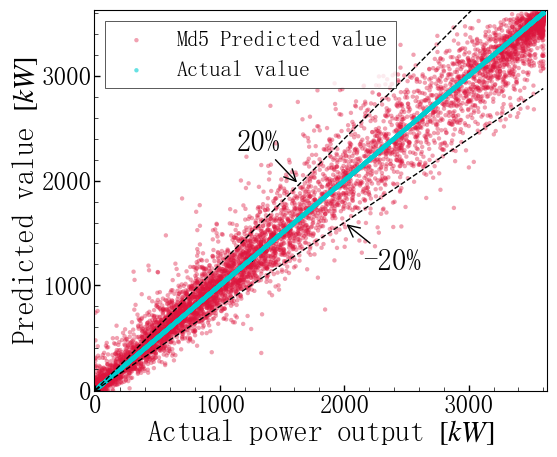

In [108]:

s=0
e=9000
result = pd.read_csv('./res/SG_9_2.csv', index_col=False)
y1 = result.values[s:e,1]
# print(y_test[s:e])
# print(y1)

yy = 3600
err = 0.2
loc = 1800
loc1 = (2*loc)/(2+err)
loc2 = (2*loc)/(2-err)

x=y_test[s:e]
plot1=y1

plt.rcdefaults()
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
config = {
            "font.family": 'serif',
            "font.size": 21,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
rcParams.update(config)

colors = ['#DC143C', '#00CED1']  #点的颜色
# fig = plt.figure(figsize=(3.5, 2.5), dpi=600)
fig,ax = plt.subplots(figsize=(6, 5), dpi=100) #注意:一般都在ax中设置,不再plot中设置
area = [10,10]  # 点面积[1.7,1.5]
plt.xlabel("Actual power output $[kW]$", fontsize=21, labelpad=1)
plt.ylabel("Predicted value $[kW]$", fontsize=21, labelpad=1.3)
plt.xlim(-10,3630)
plt.ylim(-10,3630)

plt.scatter(x, plot1, s=area[0], marker='o', c=colors[0], edgecolors='none', alpha=0.4, label='Md5 Predicted value')
plt.scatter(x, x, s=area[1], marker='o', c=colors[1], edgecolors='none', alpha=0.6, label='Actual value')

plt.plot([0,yy],[0,yy+yy*err], linewidth = 1, color='#000000', linestyle='dashed')
plt.plot([0,yy],[0,yy-yy*err], linewidth = 1, color='#000000', linestyle='dashed')

plt.annotate(str(int(err*100))+'%', xy=(loc1, loc1+loc1*err), xytext=(loc1-500, loc1+loc1*err+320),
            arrowprops=dict(arrowstyle='->', facecolor='black')
            )
plt.annotate(str(int(-1*err*100))+'%', xy=(loc2, loc2-loc2*err), xytext=(loc2+150, loc2-loc2*err-450),
            arrowprops=dict(arrowstyle='->', facecolor='black')
            )

#设置主刻度标签的位置,标签文本的格式
xmajorLocator = plt.MultipleLocator(1000) #将x主刻度标签设置为 的倍数
ax.xaxis.set_major_locator(xmajorLocator)
# xmajorFormatter = plt.FormatStrFormatter('%5.1d') #设置x轴标签文本的格式
# ax.xaxis.set_major_formatter(xmajorFormatter)

ymajorLocator = plt.MultipleLocator(1000) #将y轴主刻度标签设置为 的倍数
ax.yaxis.set_major_locator(ymajorLocator)
# ymajorFormatter = plt.FormatStrFormatter('%4.1d') #设置y轴标签文本的格式
# ax.yaxis.set_major_formatter(ymajorFormatter)

#设置次刻度标签的位置,没有标签文本格式
xminorLocator = plt.MultipleLocator(200) #将x轴次刻度标签设置为5的倍数
ax.xaxis.set_minor_locator(xminorLocator)
yminorLocator = plt.MultipleLocator(200) #将此y轴次刻度标签设置为0.1的倍数
ax.yaxis.set_minor_locator(yminorLocator)

ax.tick_params(axis='x', labelsize=18, direction='in', pad=1.8, length=4, width=1)  # 刻度值大小, rotation=40
ax.tick_params(axis='y', labelsize=18, direction='in', pad=1.8, length=4, width=1)
ax.tick_params(axis="x", which='minor', direction='in', length=2.7, width=0.5)#, color="green"
ax.tick_params(axis="y", which='minor', direction='in', length=3, width=0.5)#, color="green"

legend = plt.legend(loc='upper left' ,frameon=True,edgecolor='black', ncol=1,fancybox=False,
                    facecolor='white', fontsize=16)#loc='upper left', ,edgecolor='black', fontsize=7, bbox_to_anchor=(.6, 1)
frame = legend.get_frame()
frame.set_linewidth(0.57) # 设置图例边框线宽

plt.tight_layout()
plt.savefig('output/scatter of Power1.png', dpi=600)
plt.show()
plt.close(fig)

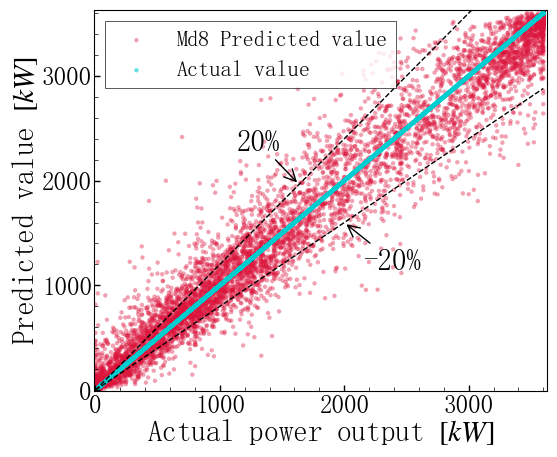

In [107]:

s=0
e=9000
result = pd.read_csv('./res/SG_17_2.csv', index_col=False)
y1 = result.values[s:e,1]
# print(y_test[s:e])
# print(y1)

yy = 3600
err = 0.2
loc = 1800
loc1 = (2*loc)/(2+err)
loc2 = (2*loc)/(2-err)

x=y_test[s:e]
plot1=y1

plt.rcdefaults()
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
config = {
            "font.family": 'serif',
            "font.size": 21,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
rcParams.update(config)

colors = ['#DC143C', '#00CED1']  #点的颜色
# fig = plt.figure(figsize=(3.5, 2.5), dpi=600)
fig,ax = plt.subplots(figsize=(6, 5), dpi=100) #注意:一般都在ax中设置,不再plot中设置
area = [10,10]  # 点面积[1.7,1.5]
plt.xlabel("Actual power output $[kW]$", fontsize=21, labelpad=1)
plt.ylabel("Predicted value $[kW]$", fontsize=21, labelpad=1.3)
plt.xlim(-10,3630)
plt.ylim(-10,3630)

plt.scatter(x, plot1, s=area[0], marker='o', c=colors[0], edgecolors='none', alpha=0.4, label='Md8 Predicted value')
plt.scatter(x, x, s=area[1], marker='o', c=colors[1], edgecolors='none', alpha=0.6, label='Actual value')

plt.plot([0,yy],[0,yy+yy*err], linewidth = 1, color='#000000', linestyle='dashed')
plt.plot([0,yy],[0,yy-yy*err], linewidth = 1, color='#000000', linestyle='dashed')

plt.annotate(str(int(err*100))+'%', xy=(loc1, loc1+loc1*err), xytext=(loc1-500, loc1+loc1*err+320),
            arrowprops=dict(arrowstyle='->', facecolor='black')
            )
plt.annotate(str(int(-1*err*100))+'%', xy=(loc2, loc2-loc2*err), xytext=(loc2+150, loc2-loc2*err-450),
            arrowprops=dict(arrowstyle='->', facecolor='black')
            )

#设置主刻度标签的位置,标签文本的格式
xmajorLocator = plt.MultipleLocator(1000) #将x主刻度标签设置为 的倍数
ax.xaxis.set_major_locator(xmajorLocator)
# xmajorFormatter = plt.FormatStrFormatter('%5.1d') #设置x轴标签文本的格式
# ax.xaxis.set_major_formatter(xmajorFormatter)

ymajorLocator = plt.MultipleLocator(1000) #将y轴主刻度标签设置为 的倍数
ax.yaxis.set_major_locator(ymajorLocator)
# ymajorFormatter = plt.FormatStrFormatter('%4.1d') #设置y轴标签文本的格式
# ax.yaxis.set_major_formatter(ymajorFormatter)

#设置次刻度标签的位置,没有标签文本格式
xminorLocator = plt.MultipleLocator(200) #将x轴次刻度标签设置为5的倍数
ax.xaxis.set_minor_locator(xminorLocator)
yminorLocator = plt.MultipleLocator(200) #将此y轴次刻度标签设置为0.1的倍数
ax.yaxis.set_minor_locator(yminorLocator)

ax.tick_params(axis='x', labelsize=18, direction='in', pad=1.8, length=4, width=1)  # 刻度值大小, rotation=40
ax.tick_params(axis='y', labelsize=18, direction='in', pad=1.8, length=4, width=1)
ax.tick_params(axis="x", which='minor', direction='in', length=2.7, width=0.5)#, color="green"
ax.tick_params(axis="y", which='minor', direction='in', length=3, width=0.5)#, color="green"

legend = plt.legend(loc='upper left' ,frameon=True,edgecolor='black', ncol=1,fancybox=False,
                    facecolor='white', fontsize=16)#loc='upper left', ,edgecolor='black', fontsize=7, bbox_to_anchor=(.6, 1)
frame = legend.get_frame()
frame.set_linewidth(0.57) # 设置图例边框线宽

plt.tight_layout()
plt.savefig('output/scatter of Power2.png', dpi=600)
plt.show()
plt.close(fig)

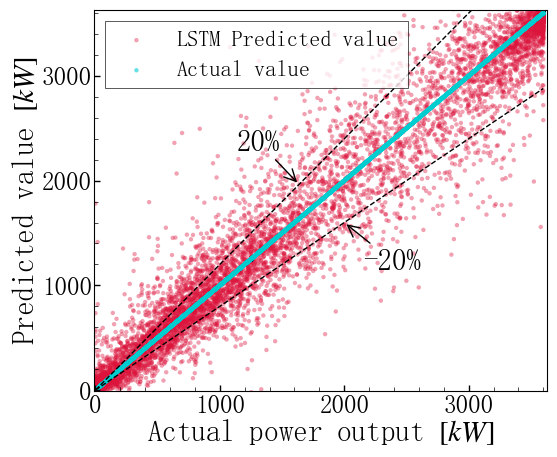

In [106]:

s=0
e=9000
result = pd.read_csv('./res/prediction_lstm.csv', index_col=False)
y1 = result.values[s:e,1]
# print(y_test[s:e])
# print(y1)

yy = 3600
err = 0.2
loc = 1800
loc1 = (2*loc)/(2+err)
loc2 = (2*loc)/(2-err)

x=y_test[s:e]
plot1=y1

plt.rcdefaults()
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
config = {
            "font.family": 'serif',
            "font.size": 21,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
rcParams.update(config)

colors = ['#DC143C', '#00CED1']  #点的颜色
# fig = plt.figure(figsize=(3.5, 2.5), dpi=600)
fig,ax = plt.subplots(figsize=(6, 5), dpi=100) #注意:一般都在ax中设置,不再plot中设置
area = [10,10]  # 点面积[1.7,1.5]
plt.xlabel("Actual power output $[kW]$", fontsize=21, labelpad=1)
plt.ylabel("Predicted value $[kW]$", fontsize=21, labelpad=1.3)
plt.xlim(-10,3630)
plt.ylim(-10,3630)

plt.scatter(x, plot1, s=area[0], marker='o', c=colors[0], edgecolors='none', alpha=0.4, label='LSTM Predicted value')
plt.scatter(x, x, s=area[1], marker='o', c=colors[1], edgecolors='none', alpha=0.6, label='Actual value')

plt.plot([0,yy],[0,yy+yy*err], linewidth = 1, color='#000000', linestyle='dashed')
plt.plot([0,yy],[0,yy-yy*err], linewidth = 1, color='#000000', linestyle='dashed')

plt.annotate(str(int(err*100))+'%', xy=(loc1, loc1+loc1*err), xytext=(loc1-500, loc1+loc1*err+320),
            arrowprops=dict(arrowstyle='->', facecolor='black')
            )
plt.annotate(str(int(-1*err*100))+'%', xy=(loc2, loc2-loc2*err), xytext=(loc2+150, loc2-loc2*err-450),
            arrowprops=dict(arrowstyle='->', facecolor='black')
            )

#设置主刻度标签的位置,标签文本的格式
xmajorLocator = plt.MultipleLocator(1000) #将x主刻度标签设置为 的倍数
ax.xaxis.set_major_locator(xmajorLocator)
# xmajorFormatter = plt.FormatStrFormatter('%5.1d') #设置x轴标签文本的格式
# ax.xaxis.set_major_formatter(xmajorFormatter)

ymajorLocator = plt.MultipleLocator(1000) #将y轴主刻度标签设置为 的倍数
ax.yaxis.set_major_locator(ymajorLocator)
# ymajorFormatter = plt.FormatStrFormatter('%4.1d') #设置y轴标签文本的格式
# ax.yaxis.set_major_formatter(ymajorFormatter)

#设置次刻度标签的位置,没有标签文本格式
xminorLocator = plt.MultipleLocator(200) #将x轴次刻度标签设置为5的倍数
ax.xaxis.set_minor_locator(xminorLocator)
yminorLocator = plt.MultipleLocator(200) #将此y轴次刻度标签设置为0.1的倍数
ax.yaxis.set_minor_locator(yminorLocator)

ax.tick_params(axis='x', labelsize=18, direction='in', pad=1.8, length=4, width=1)  # 刻度值大小, rotation=40
ax.tick_params(axis='y', labelsize=18, direction='in', pad=1.8, length=4, width=1)
ax.tick_params(axis="x", which='minor', direction='in', length=2.7, width=0.5)#, color="green"
ax.tick_params(axis="y", which='minor', direction='in', length=3, width=0.5)#, color="green"

legend = plt.legend(loc='upper left' ,frameon=True,edgecolor='black', ncol=1,fancybox=False,
                    facecolor='white', fontsize=16)#loc='upper left', ,edgecolor='black', fontsize=7, bbox_to_anchor=(.6, 1)
frame = legend.get_frame()
frame.set_linewidth(0.57) # 设置图例边框线宽

plt.tight_layout()
plt.savefig('output/scatter of Power3.png', dpi=600)
plt.show()
plt.close(fig)